# INM706 - Deep Learning for Sequence Analysis

Authors: Laerte Adami - Elisa Troschka

Source: 
- https://towardsdatascience.com/a-comprehensive-guide-to-neural-machine-translation-using-seq2sequence-modelling-using-pytorch-41c9b84ba350#30b6
- https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#evaluation

Blue Score:
- https://towardsdatascience.com/foundations-of-nlp-explained-bleu-score-and-wer-metrics-1a5ba06d812b

In [1]:
from torchtext.data.metrics import bleu_score

candidate_corpus = [['The', 'cat', 'is', 'on','the','table']]
references_corpus = [
    
        [['The', 'cat', 'is', 'on','the','table']]]

print(len(candidate_corpus))
print(len(references_corpus))
    
                    
bleu_score(candidate_corpus, references_corpus,max_n=4, weights=[0.25, 0.25, 0.25,0.25])

ImportError: /opt/apps/flight/env/conda+jupyter/lib/python3.9/site-packages/torchtext/_torchtext.so: undefined symbol: _ZNK3c104Type14isSubtypeOfExtERKSt10shared_ptrIS0_EPSo

In [1]:
# Custom functionalities
from Utilities.lstmHandler import EncoderLSTM, DecoderLSTM, AttentionDecoderLSTM
from Utilities.modelHandler import LSTModel
from Utilities.LanguageDataset import LanguageDataset

import time
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss as CEL
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

plt.rcParams['font.size'] = 17

In [2]:
## DATASET PARAMETERS ##
data_path = "Data/eng_ita.tsv"
limit_data = 500
start_token = '<BoS>'
end_token = '<EoS>'
seq_len = 10
embedding_size = 256
batch_size = 100

# Import datasets
dataset = LanguageDataset(data_path = data_path, start_token = start_token, end_token = end_token, seq_len = seq_len, limit_data = limit_data)
train_set, val_set, test_set = dataset.get_datasets()

end_index = dataset.from_ita[end_token]
start_index = dataset.from_ita[start_token]

# Create dataloaders
trainloader = DataLoader(train_set, batch_size = batch_size)
valloader = DataLoader(val_set, batch_size = batch_size)
testloader = DataLoader(test_set, batch_size = batch_size)

# Vocabulary for BLUE score
blue_voc = dataset.blue_score_test

print("English vocabulary size for training: {}".format(dataset.eng_voc_size))
print("Italian vocabulary size for training: {}".format(dataset.ita_voc_size))
print("--------------------------------------------")
print("Train set dimension: {}".format(train_set.__len__()))
print("Val set dimension: {}".format(val_set.__len__()))
print("Test set dimension: {}".format(test_set.__len__()))

English vocabulary size for training: 509
Italian vocabulary size for training: 743
--------------------------------------------
Train set dimension: 356
Val set dimension: 39
Test set dimension: 105


## Model defition

In [3]:
encoder = EncoderLSTM(vocabulary_size = dataset.eng_voc_size,
                     embedding_size = embedding_size,
                     num_layers = 1, 
                     bidirectional = False)

#decoder = DecoderLSTM(vocabulary_size = dataset.ita_voc_size,
#                     embedding_size = embedding_size,
#                     num_layers = 1, 
#                     bidirectional = False)

decoder = AttentionDecoderLSTM(vocabulary_size = dataset.ita_voc_size,
                     embedding_size = embedding_size,
                     seq_len = dataset.seq_len,
                     num_layers = 1, 
                     bidirectional = False)

loss_func = CEL()
learning_rate = 1e-3
model = LSTModel(encoder = encoder, 
                 decoder = decoder, 
                 encoder_optimizer = Adam(encoder.parameters(), lr = learning_rate), 
                 decoder_optimizer = Adam(decoder.parameters(), lr = learning_rate),
                 loss_function = loss_func, 
                 eos_token = end_index, 
                 bos_token = start_index)

## Model training

EPOCH 1: train loss = 5.601, validation loss = 5.027
EPOCH 2: train loss = 4.53, validation loss = 4.648
EPOCH 3: train loss = 4.043, validation loss = 4.513
EPOCH 4: train loss = 3.833, validation loss = 4.535
EPOCH 5: train loss = 3.674, validation loss = 4.632
EPOCH 6: train loss = 3.551, validation loss = 4.608
EPOCH 7: train loss = 3.433, validation loss = 4.648
EPOCH 8: train loss = 3.32, validation loss = 4.639
EPOCH 9: train loss = 3.197, validation loss = 4.644
EPOCH 10: train loss = 3.074, validation loss = 4.711
--------------------------------
Time required: 6.326549530029297


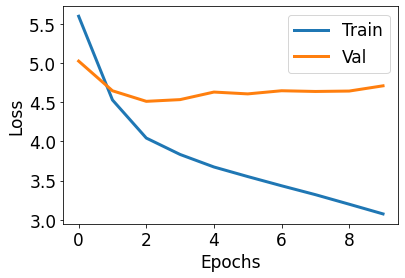

In [4]:
start_time = time.time()
L_train, L_val = model.train_model(trainloader,
                      valloader,
                      max_epochs = 10,
                      save_every_epochs = 10,
                      ckp_name = 'test')
print("--------------------------------")
print("Time required: {}".format(time.time()-start_time))
      
fig, ax = plt.subplots()
ax.plot(L_train, linewidth = 3, label = "Train")
ax.plot(L_val, linewidth = 3, label = "Val")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend();

## Model evaluation

In [5]:
enc_ckp = "test_enc_10.pth"
dec_ckp = "test_dec_10.pth"

X, y, trans = model.evaluate_model(testloader, enc_ckp = enc_ckp, dec_ckp = dec_ckp)

X_blue = dataset.translate(X,"eng")
y_blue = dataset.translate(y,"ita")
trans_blue = dataset.translate(trans,"ita")

In [6]:
X[1:5]

tensor([[300, 280, 180,  42, 141, 292, 444, 421, 433, 219],
        [300, 280, 471, 411, 180, 292, 478, 219, 136, 136],
        [300, 385, 326,  49, 263, 149, 356, 281, 404, 219],
        [300, 292, 159, 415, 219, 136, 136, 136, 136, 136]], device='cuda:0')

In [7]:
X_blue[1:5]

[['What', 'do', 'you', 'think', 'I', 've', 'been', 'doing'],
 ['What', 'other', 'options', 'do', 'I', 'have'],
 ['It', 's', 'not', 'much', 'of', 'a', 'surprise', 'is'],
 ['I', 'hate', 'chemistry']]

In [32]:
' '.join(X_blue[20])

'I suppose it s different when you think'

In [15]:
blue_voc#[' '.join(X_blue[3])]

{'The phone is ringing I ll get it': [['Il',
   'telefono',
   'sta',
   'suonando',
   'Rispondo',
   'io']],
 'What do you think I ve been doing': [['Cosa',
   'credi',
   'che',
   'stessi',
   'facendo']],
 'What other options do I have': [['Quali', 'altre', 'opzioni', 'ho']],
 'It s not much of a surprise is it': [['Non',
   'è',
   'proprio',
   'una',
   'sorpresa',
   'no']],
 'I hate chemistry': [['Detesto', 'la', 'chimica']],
 'You wanted to tell me about freedom': [['Mi',
   'volevi',
   'parlare',
   'di',
   'libertà']],
 'You re not fast enough': [['Non', 'sei', 'abbastanza', 'veloce'],
  ['Tu', 'non', 'sei', 'abbastanza', 'veloce'],
  ['Non', 'siete', 'abbastanza', 'veloci'],
  ['Voi', 'non', 'siete', 'abbastanza', 'veloci'],
  ['Non', 'è', 'abbastanza', 'veloce'],
  ['Lei', 'non', 'è', 'abbastanza', 'veloce']],
 'I hate it when there are a lot of people': [['Odio',
   'quando',
   'ci',
   'sono',
   'molte',
   'persone'],
  ['Io', 'odio', 'quando', 'ci', 'sono', 'molt

In [32]:
ids = 34
print("English: " + ' '.join(X_blue[ids]))
print("Italian: " + ' '.join(y_blue[ids]))
print("Translation: " + ' '.join(trans_blue[ids]))

English: Oh I m sorry
Italian: Oh sono dispiaciuta
Translation: Non


In [24]:
ids = 12
print("English: " + ' '.join(X_blue[ids]))
print("Italian: " + ' '.join(y_blue[ids]))
print("Translation: " + ' '.join(trans_blue[ids]))

English: We have five English classes a week
Italian: Abbiamo cinque lezioni di inglese alla settimana
Translation: Noi siamo un un un


In [25]:
ids = 67
print("English: " + ' '.join(X_blue[ids]))
print("Italian: " + ' '.join(y_blue[ids]))
print("Translation: " + ' '.join(trans_blue[ids]))

English: He deceives others with his appearance
Italian: Inganna gli altri con il suo aspetto
Translation: Noi ha la la la
